# DSCI100-32: Star Classification ⭐

## Introduction:

Star classification is an emerging field of research used to better understand the galaxies which surround us. Determining star types is vital in the research of extraterrestrial life, understanding stellar evolution, and predicting the future behaviour of our sun. 
Our group will be working on the Star Dataset for Stellar Classification dataset from Kaggle. In the field of astronomy, star classification is based on several spectral characteristics, including apparent and absolute magnitude, spectral type, and colour index.

We will use these predictors to calibrate whether we can correctly predict the chemical composition (spectral class) of an unknown star using the factors and information provided through the dataset.


In [50]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(ggplot2)
install.packages('kknn')
install.packages("cowplot")

#essential modules that are required in order to run most of our data analysis and given to us throughout DSCI100 

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [51]:
colname = c("Vmag","distance","error_distance","color_index","spectral_type","Amag","Class")
stars <- read_csv("stars.csv", col_names = colname, skip = 1)
#Rewriting column names to more readable usages for overall data manipulation


Rows: 3642 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): spectral_type
dbl (6): Vmag, distance, error_distance, color_index, Amag, Class

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [52]:
stars #Briefly viewing the table before analysis

Vmag,distance,error_distance,color_index,spectral_type,Amag,Class
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
5.99,13.73,0.58,1.318,K5III,16.67835,0
8.70,2.31,1.29,-0.045,B1II,15.51806,0
5.77,5.50,1.03,0.855,G5III,14.47181,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.11,2.42,0.79,1.664,M0/M1IIICNp,13.02908,0
7.94,4.94,2.90,0.210,A5V,16.40864,1
8.81,1.87,1.23,1.176,K1/K2III,15.16921,0


Table 1: Data set taken from Kaggle

In [53]:
stars <- stars |>
    mutate(spectral_type = case_when(grepl("K",spectral_type) ~ "K", 
                                grepl("B",spectral_type) ~ "B", 
                                grepl("G",spectral_type) ~ "G", 
                                grepl("M",spectral_type) ~ "M", 
                                grepl("A",spectral_type) ~ "A",
                                grepl("F",spectral_type) ~ "F",
                                grepl("O",spectral_type) ~ "O",
                                grepl("C",spectral_type) ~ "C")) |>
    mutate(spectral_type = as_factor(spectral_type)) #Mutation of spectral type into a factor so it may be predicted
stars

Vmag,distance,error_distance,color_index,spectral_type,Amag,Class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
5.99,13.73,0.58,1.318,K,16.67835,0
8.70,2.31,1.29,-0.045,B,15.51806,0
5.77,5.50,1.03,0.855,G,14.47181,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.11,2.42,0.79,1.664,M,13.02908,0
7.94,4.94,2.90,0.210,A,16.40864,1
8.81,1.87,1.23,1.176,K,15.16921,0


Table 2: Data set with distinct factors for Spectral Type

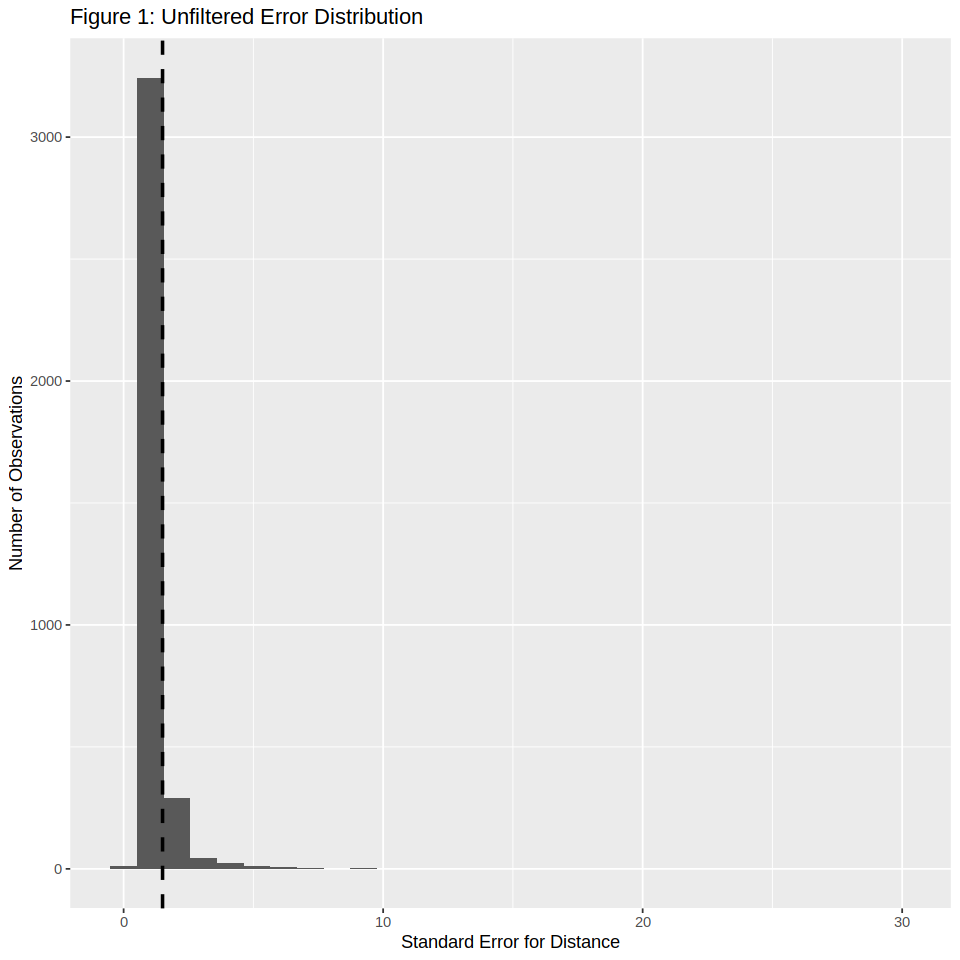

In [54]:
options(repr.plot.height = 8, repr.plot.width = 8)
error_remove_plot <- stars |>
    ggplot(aes(x = error_distance)) + 
    geom_histogram(bins = 30) +
    geom_vline(xintercept = 1.50, linetype = "dashed", linewidth = 1) +
    xlab("Standard Error for Distance") + 
    ylab("Number of Observations") +
    ggtitle("Figure 1: Unfiltered Error Distribution")


error_remove_plot

This plot shows the number of error values for the distance. The values left of the vertical line will be kept and the values to the right will be discarded. 

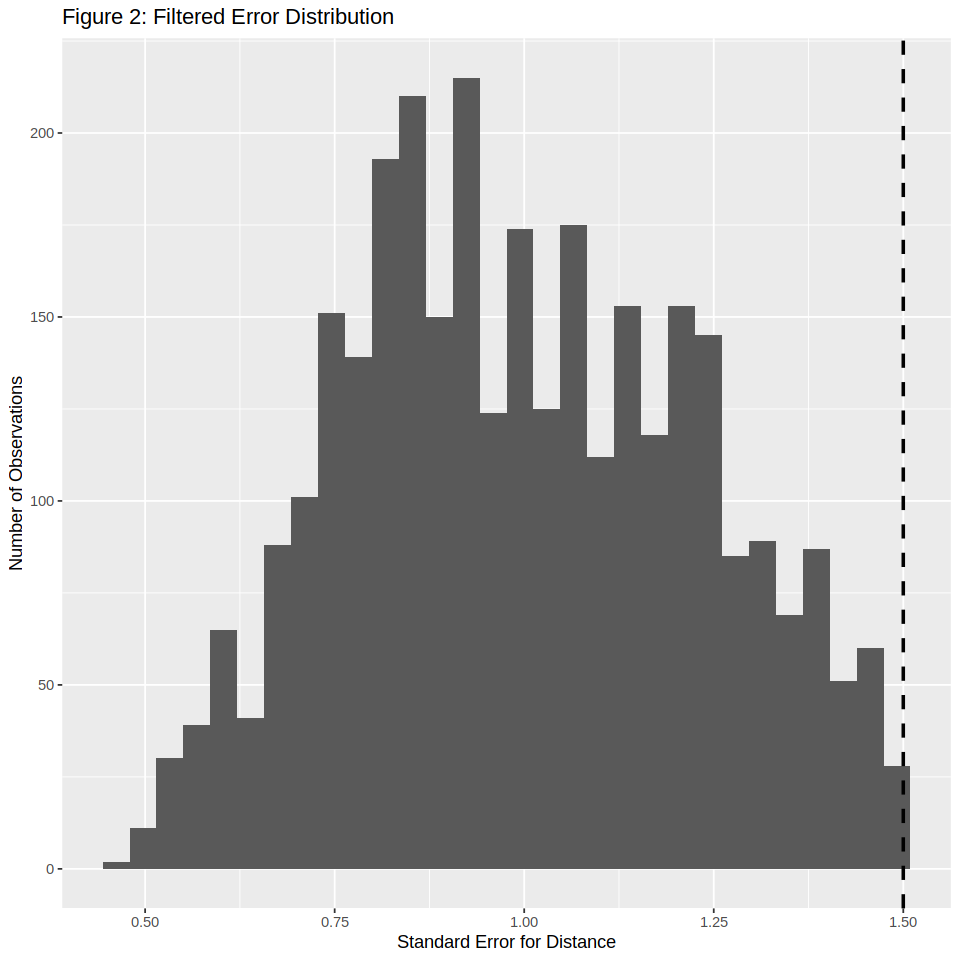

In [55]:
options(repr.plot.height = 8, repr.plot.width = 8)
final_error_plot <- stars |>
    filter(error_distance < 1.50) |>
    ggplot(aes(x = error_distance)) + 
    geom_histogram(bins = 30) +
    geom_vline(xintercept = 1.50, linetype = "dashed", linewidth = 1) +
    xlab("Standard Error for Distance") +
    ylab("Number of Observations") +
    ggtitle("Figure 2: Filtered Error Distribution")

final_error_plot

The dataset will be adjusted according to the information found above. 
After the error distance is used to remove data points, the column has no further use.

In [56]:
stars <- stars |>
    filter(error_distance < 1.50)|>
    select( Vmag, distance, color_index, spectral_type, Amag ,Class)

stars

Vmag,distance,color_index,spectral_type,Amag,Class
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
5.99,13.73,1.318,K,16.67835,0
8.70,2.31,-0.045,B,15.51806,0
5.77,5.50,0.855,G,14.47181,0
⋮,⋮,⋮,⋮,⋮,⋮
8.29,6.38,0.408,F,17.31410,1
6.11,2.42,1.664,M,13.02908,0
8.81,1.87,1.176,K,15.16921,0


Table 3: Data set with Filtered Distance 

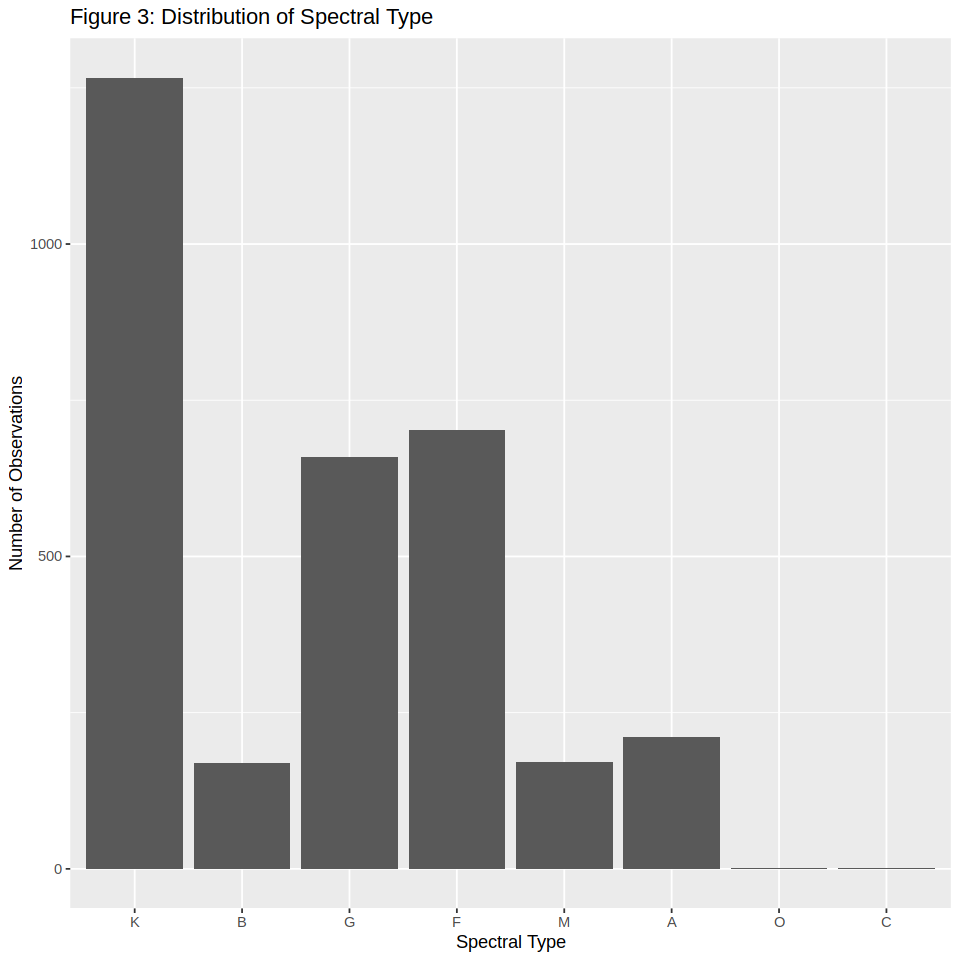

In [57]:
options(repr.plot.width = 8, repr.plot.height = 8)
spectral_plot <- stars |>
    ggplot(aes(x = spectral_type)) + 
    geom_bar() + 
    labs(x = "Spectral Type", y = "Number of Observations") +
    ggtitle("Figure 3: Distribution of Spectral Type")

spectral_plot

As shown in the Figure above, there are a very limited number of observations with the spectral type O and C. Due to this, these types will be removed. 

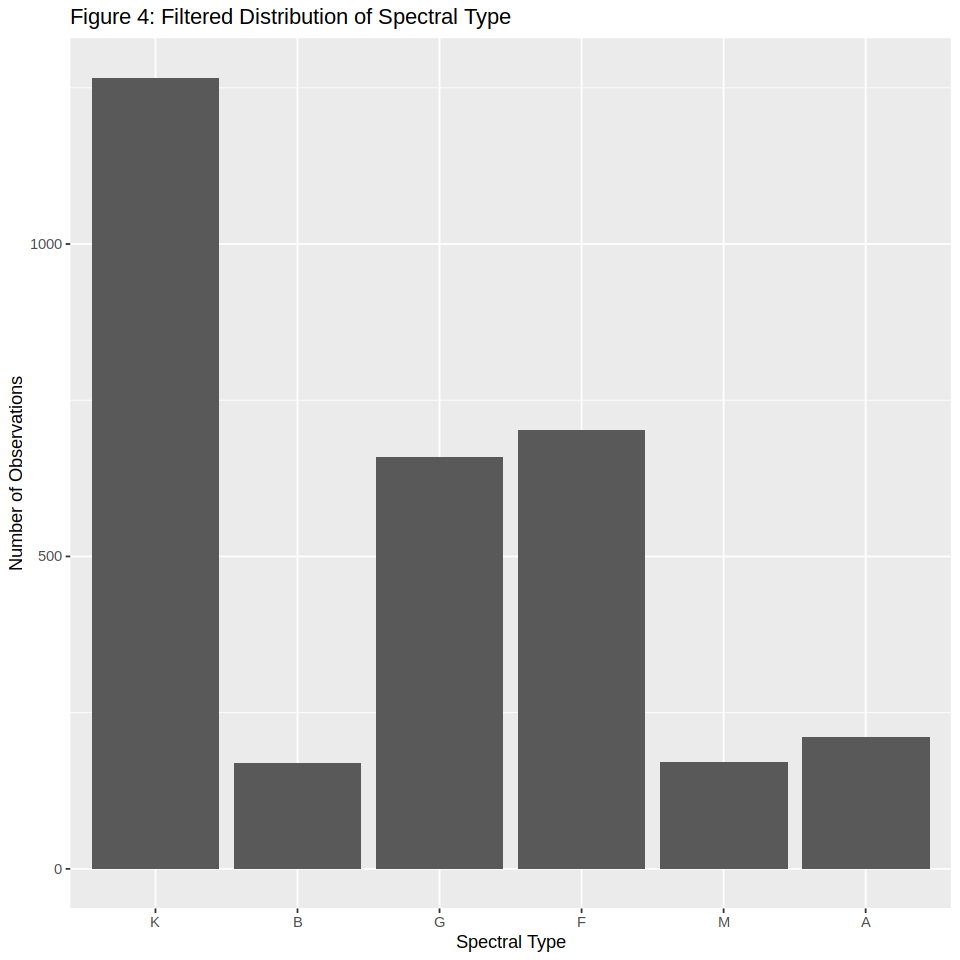

In [58]:
stars <- stars |>
    filter( spectral_type != "O", spectral_type != "C")

options(repr.plot.width = 8, repr.plot.height = 8)
filtered_spectral_plot <- stars |>
    ggplot(aes(x = spectral_type)) + 
    geom_bar() + 
    labs(x = "Spectral Type", y = "Number of Observations") +
    ggtitle("Figure 4: Filtered Distribution of Spectral Type")

filtered_spectral_plot

The absolute magnitude is not a qualitative observation(see method) and will be removed.

In [59]:
stars <- select(stars, -Amag)

stars

Vmag,distance,color_index,spectral_type,Class
<dbl>,<dbl>,<dbl>,<fct>,<dbl>
5.99,13.73,1.318,K,0
8.70,2.31,-0.045,B,0
5.77,5.50,0.855,G,0
⋮,⋮,⋮,⋮,⋮
8.29,6.38,0.408,F,1
6.11,2.42,1.664,M,0
8.81,1.87,1.176,K,0


Table 4: Data Set with Absolute Magnitude removed

With this, the data set is now tidy, with the unneeded data removed. Moving forward, we will now split the data with 75% of the data being put into the training data, and 25% being put into the testing data.

In [60]:
set.seed(2000)

star_split <- initial_split(stars, prop = 0.75, strata = spectral_type)
star_train <- training(star_split)
star_test <- testing(star_split) 

In [61]:
class_count <- star_train|>
    select(Class)|>
    group_by(Class)|>
    count(Class)

class_count

Class,n
<dbl>,<int>
0,1291
1,1093


Table 5: Observations Classified as Giant(1) or Dwarf(0) in the Training Data

In [62]:
predictor_means <- star_train |>
    select(Vmag:color_index, Class) |>
    map_df(mean)

predictor_means

Vmag,distance,color_index,Class
<dbl>,<dbl>,<dbl>,<dbl>
7.923872,7.668507,0.8513721,0.4584732


Table 6: The Average of all the predictors that are used.

This table illuminates the necessity of standardizing the data.

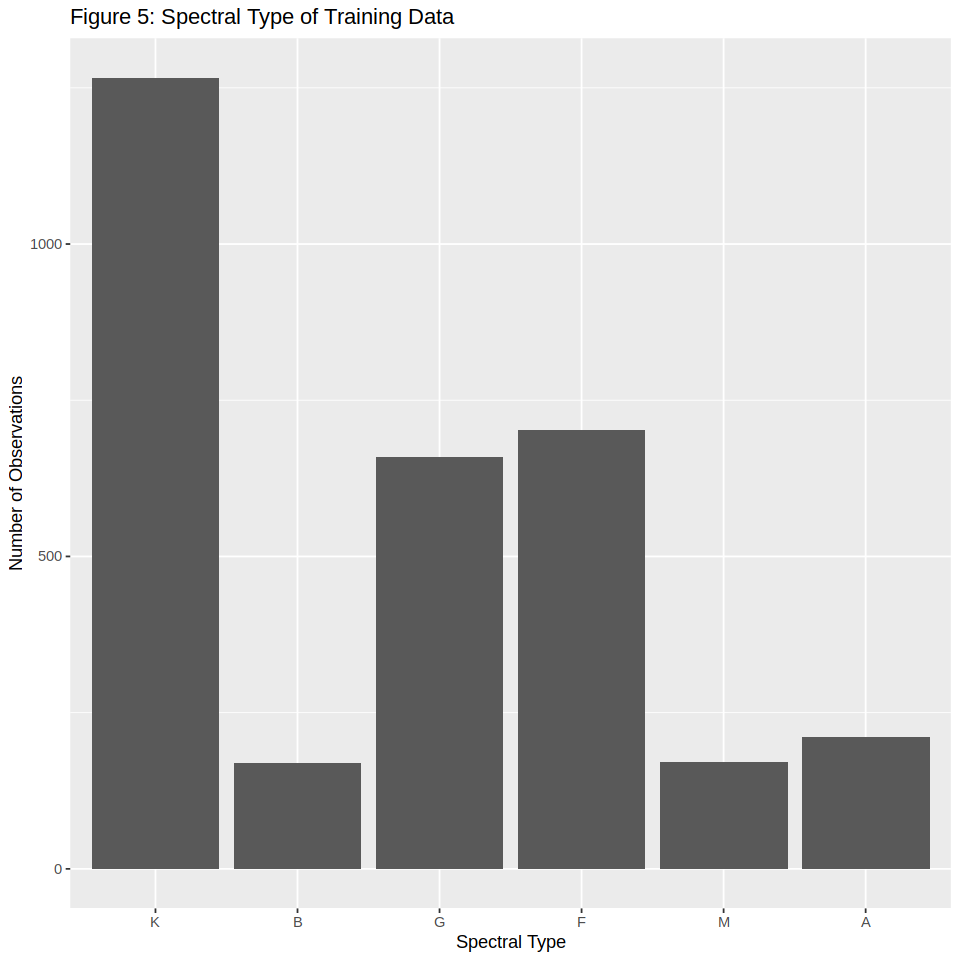

In [63]:
spectral_training_plot <- stars |>
    ggplot(aes(x = spectral_type)) + 
    geom_bar() +
    labs(x = "Spectral Type", y = "Number of Observations") +
    ggtitle("Figure 5: Spectral Type of Training Data")
    

spectral_training_plot

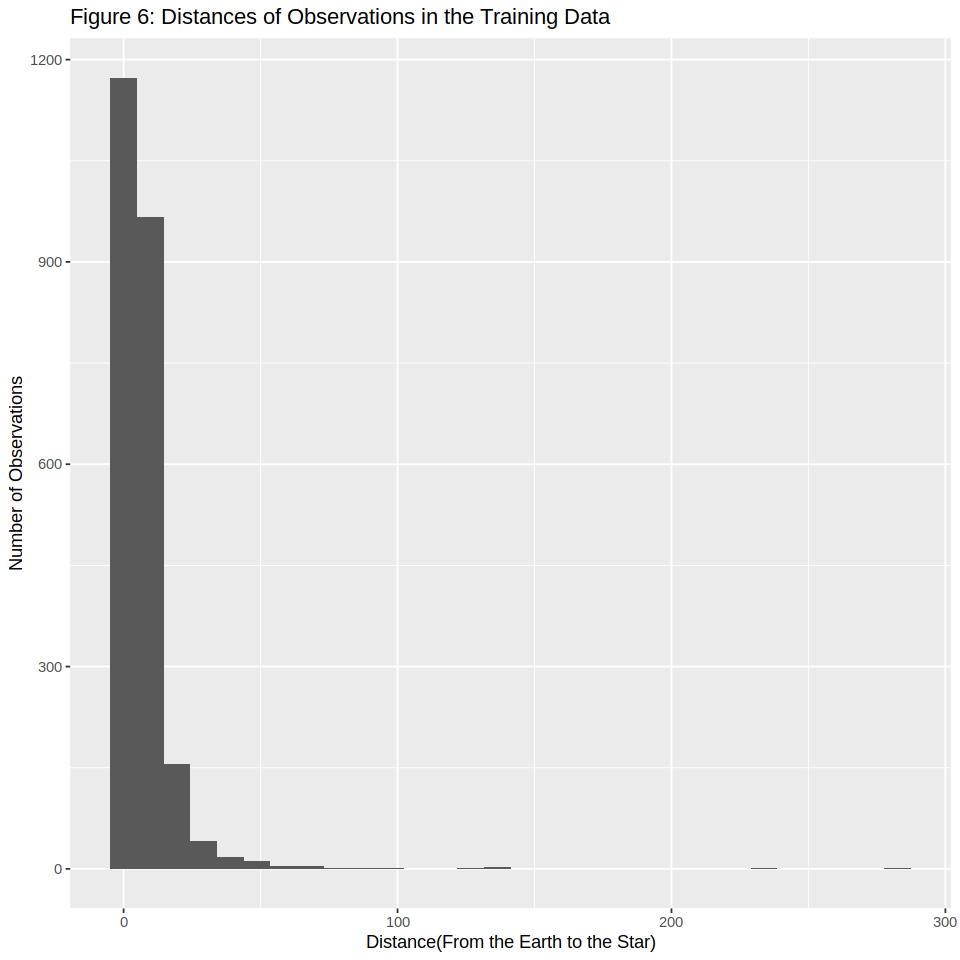

In [64]:
distance_training_plot <- star_train |>
    ggplot(aes(x = distance)) + 
    geom_histogram(bins = 30) +
    labs(x = "Distance(From the Earth to the Star)", y = "Number of Observations") +
    ggtitle("Figure 6: Distances of Observations in the Training Data")
    
distance_training_plot


## Methods:

In order to make our model more simple, we will be limiting the spectral type to the main classes(represented by the letters), disregarding the various sub-classes that are simply various sub-levels of the main classes anyways. Using the standard error for distance, we will remove any observations that have an extraneous amount of standard error. We will then use the visual apparent magnitude(lux), the distance between the Star and Earth(parallax), spectral colour index(B-V) and whether the star is a giant or dwarf, to predict the spectral type of a new star. These predictors are used due to all of them being observed quantities. All of these predictors have an impact on the spectral type. The absolute magnitude of the star was excluded in this set of predictors as it is not an observed value, but instead a value calculated from the apparent magnitude and distance. We will be using the kNN algorithm to classify new observations. First, we will find the optimal number of neighbours that maximize the accuracy of our model. Then we will apply our findings to a new model. 


## Expected Outcomes and Significance:
With this completed model, the spectral type of a star can be determined so long as the apparent magnitude, distance from the Earth, colour index, and whether the star is a giant or dwarf is known. Understanding the spectral type of a star is significant, as it provides a plethora of information about the star and even our universe as a whole. If we can derive the identity of a Spectral Class of a star, chemists could be able to examine the cosmic age of the star and approximate the period until which a star depletes its chemical reactants and either burns out or becomes a supernova. The knowledge associated with the Spectral Class, such as the star's size and its temperatures could also significantly aid in further exploration of the surrounding star systems.

First, we will create a recipe that will be used for both the tuning model and the final model. The recipe will use all of the kept predictors while scaling and centering them. 

In [65]:
set.seed(2000)

star_recipe <- recipe(spectral_type ~ ., data = star_train)|>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

Next, we will create a tuning model. 

In [66]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

We will now use the 5-fold cross-validation and determine the estimated accuracy that each number of neighbors. 

In [67]:
star_vfold <- vfold_cv(star_train, v = 5, strata = spectral_type)

star_tuning_fit <- workflow() |>
    add_recipe(star_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = star_vfold, grid = tibble(neighbors = c(1:15))) |>
    collect_metrics()


! Fold1: internal:
  There were 15 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): 'O', 'C'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 14 ...

! Fold2: internal:
  There were 15 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): 'O', 'C'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 14 ...

! Fold3: internal:
  There were 15 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s)

By plotting the estimated accuracy of the model that each number of neighbors have, we will be able to identify number of neighbors that results in the most accurate model.

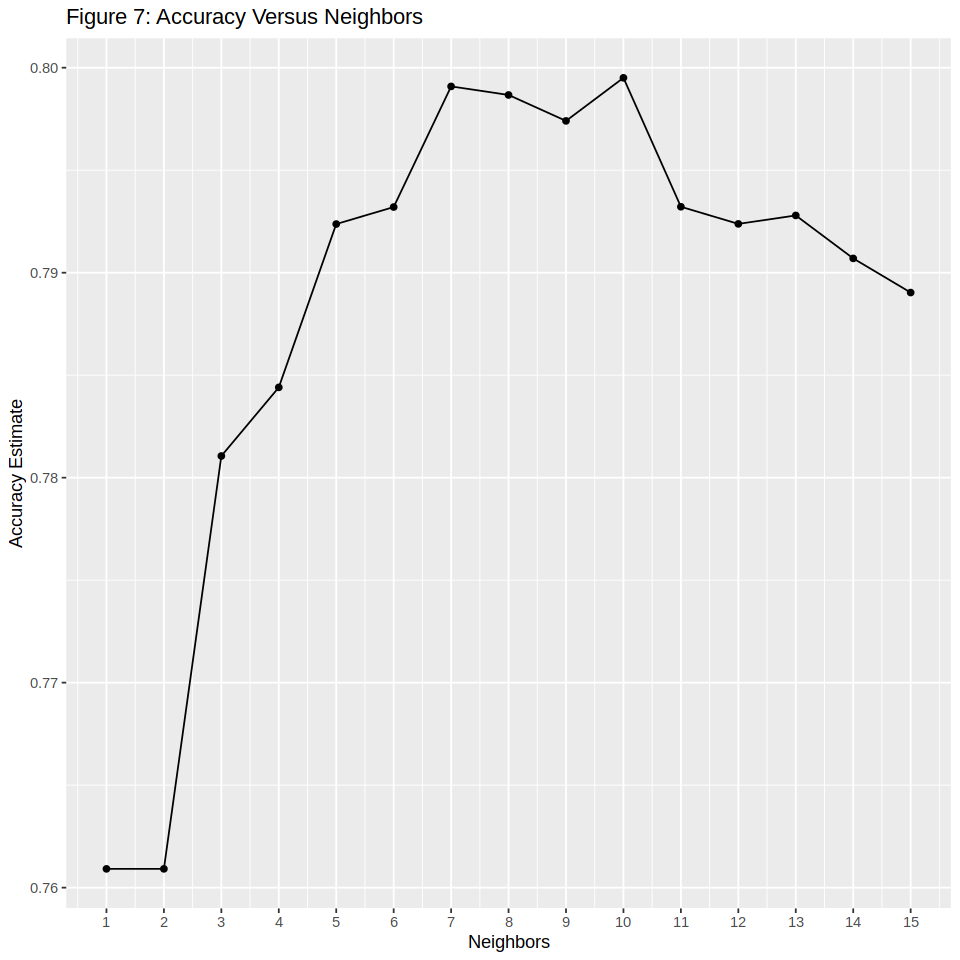

In [68]:
accuracies <- star_tuning_fit |>
    filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(1, 15, by = 1)) +
    ggtitle("Figure 7: Accuracy Versus Neighbors")

accuracy_versus_k

Judging from the plot above, it would be optimal to use 10 neighbors.

We will then create a new model using 10 neighbors.

In [69]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
    set_engine("kknn") |>
    set_mode("classification")

star_fit <- workflow() |>
       add_recipe(star_recipe) |>
       add_model(knn_spec) |>
       fit(data = star_train)
star_fit



══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(10,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2000839
Best kernel: rectangular
Best k: 10

In [70]:
star_test_prediction <- predict(star_fit , star_test) |>
       bind_cols(star_test)

star_test_prediction

.pred_class,Vmag,distance,color_index,spectral_type,Class
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
F,7.57,8.67,0.528,F,1
M,7.58,3.47,1.626,M,0
A,8.27,1.62,0.146,B,1
⋮,⋮,⋮,⋮,⋮,⋮
F,8.81,5.71,0.512,F,1
A,7.23,4.91,0.010,A,1
K,6.64,4.46,1.301,K,0


Table 7: The Predicted Spectral Type of the Testing Data

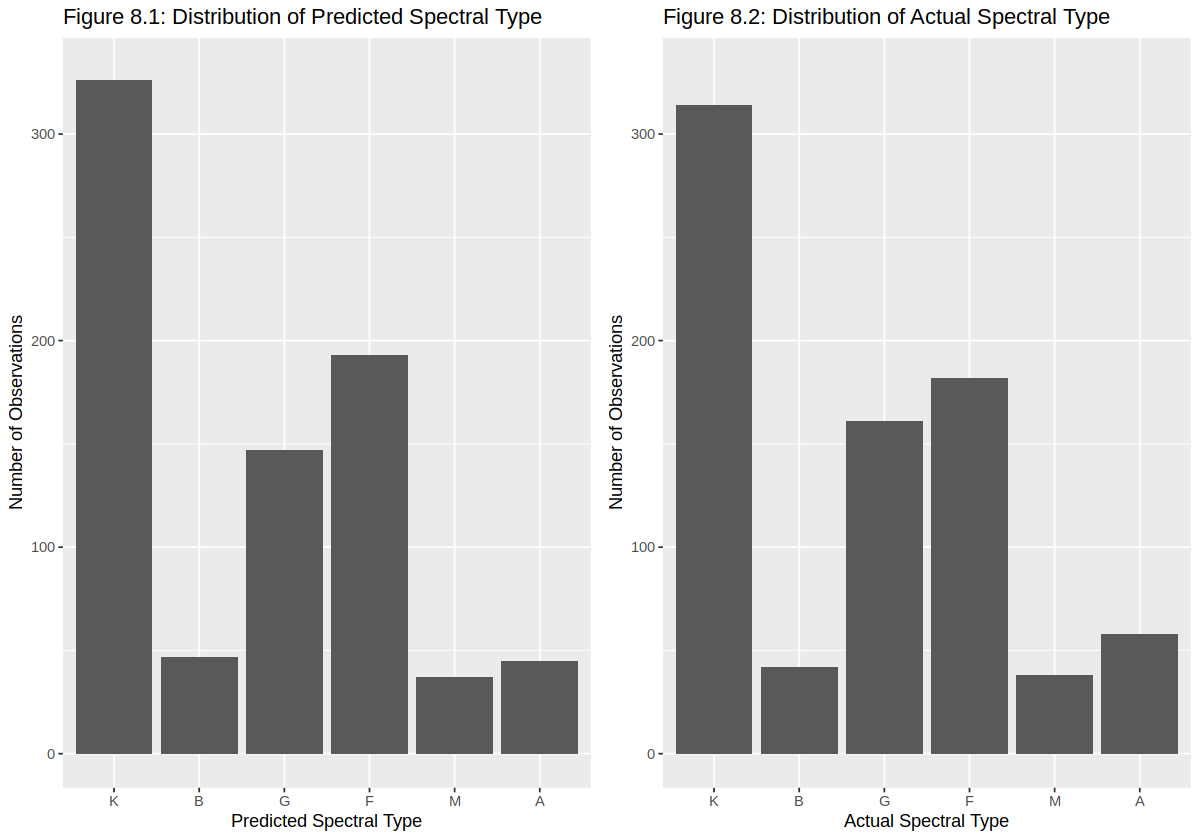

In [82]:
options(repr.plot.width = 10, repr.plot.height = 7)
predicted_plot <- star_test_prediction |>
        ggplot(aes(x = .pred_class)) +
        geom_bar() + 
        xlab("Predicted Spectral Type") +
        ylab("Number of Observations") +
        ggtitle("Figure 8.1: Distribution of Predicted Spectral Type") +
        ylim(0, 330)

options(repr.plot.width = 10, repr.plot.height = 7)
actual_plot <- star_test_prediction |>
        ggplot(aes(x = spectral_type)) +
        geom_bar() + 
        xlab("Actual Spectral Type") +
        ylab("Number of Observations") +
        ggtitle("Figure 8.2: Distribution of Actual Spectral Type") +
        ylim(0, 330)



plot_grid(predicted_plot, actual_plot, ncol = 2)


These plots show the comparison between the predicted and the actual spectral type of the observations. As shown above, the variance between the predicted and actual value for each spectral type is minimal.

In [ ]:
star_prediction_accuracy <- star_test_prediction |>
         metrics(truth = spectral_type, estimate = .pred_class) 
star_prediction_accuracy

Table 8: The predicted accuracy estimate of the model

As shown above, the accuracy estimate for the optimal workflow is 78.5%. As an example of the applications of the model, the predictors of the star Polaris were used with the model.

In [ ]:
obs_polaris <- tibble(Vmag = 8.7, distance = 7.54, color_index = 0.42, Class = 1)


predict(star_fit, obs_polaris)

The model predicted that Polaris would have a spectral type of F. Due to our preexisting knowledge of Polaris, we can confirm that this is correct. (Evans et al., 2008)

## Discussion

Through our exploration of the information in our data set, we have been able to create a model that can predict the spectral type of a star with 78.5 percent accuracy. While this was what we aimed to achieve, the model does have some significant drawbacks. Our model is unable to correctly classify a star of type O or C. This is because our original data set lacked sufficient information on the two classes, and the classes were ultimately removed the the model entirely. 


## Conclusion
In this project, a machine learning model based on the k-Nearest Neighbour (k-NN) algorithm was successfully developed by us and trained to predict the spectral type of stars. The model is trained using some of the prominent features of the star like visual magnitude (Vmag), distance, and chromatic index and by classifying it to be a giant or not. During the data pre-processing, in particular, there were a few limitations with the dataset where stars with high differences and standard errors were filtered out and simplifications made on spectral types by removal of a number of the sub-categories.  After the training, the model has an approximate accuracy of 78.5% in predicting stellar spectral types, a level of performance that's good enough. However, we also found important limitations of the model. As it wasn't enough information in the original training dataset about type O and type C stars, these two types were classified as poor.  This observation, stresses the importance of a good and rationed training dataset for any machine learning project. Overall, the project shows not just the prowess in using machine learning techniques in the field of astronomy but also the ever-important factor of quality data in building strong modelling systems.

We believe that this project aligns with the background of machine learning and data availability in several ways:
Firstly, the project has yielded positive and successful outcomes in terms of the model's predicted accuracy. Achieving an accuracy of 78.5% indicates that our earlier efforts in data preprocessing and model training have been effective. This high level of accuracy can be utilised for the automated classification of stars, saving considerable time and human resources. The strong performance of the model provides valuable assistance for further research and analysis, offering valuable insights and support for future work in the field of astronomy.
However, it is also important to discuss the limitations that were within our expectations. The model's inability to accurately classify O-type and C-type stars to some extent aligns with our prior expectations. Given the constraints of the available data, the performance of a machine learning model heavily relies on the quality and diversity of the training data. If certain categories have limited data representation, the model's performance in those areas may be affected. Therefore, this limitation underscores the significance of having a comprehensive dataset.

In conclusion, while this project has revealed certain limitations of the model, it does not diminish its importance. It has provided valuable insights into how machine learning can be applied to process astronomical data and encourages us to continuously improve both data and models to gain a better understanding of stars in the universe.

These findings could hold great significance for astronomy and its associated fields. Knowledge of a star's spectral class and as a result, its age, provides the ability to predict the future fate of the star, including the time it would take for a star to exhaust its fuel, and to become a supernova. The spectral type of a star has a direct correlation to its surface temperature, and as such, classifying a star's spectral type would allow astronomers to approximate its luminosity - the amount of energy outputted by a star - enabling us to better identify which state of evolution a star is undergoing. When observing distant stars, knowledge of the relationship between spectral type and luminosity would empower researchers to estimate the brightness of stars, and as such, our distance to them.

Additionally, spectral types can offer valuable insight as to the chemical makeup and composition of a star. Stellar classification is based on spectral type, denoted by letters O, B, A, F, G, K, M - in descending order of heat. Astronomers have assigned each spectral type a pattern of absorption lines. Determined by the nature of the spectrum emitted from a star, these lines show how a spectrum reacts as it passes through a gas. Every element will leave a different imprint on the spectrum, and as such, the variance between the wavelengths of these absorption lines provides vital information about the types, as well as the abundance of elements present in the star. 

We could expand on our findings by employing kNN regression. Regression has a documented history of use in astronomical research, primarily to determine the redshift, the change in wavelength of an absorption line. Features of the spectrum are applied to a kNN regression model, and then assigned a redshift value. For our purposes, however, regression could be used to determine quantitative features of a star - such as temperature and luminosity. Alternatively, regression would allow us to explore the the chemical makeup of a star in greater detail. We would use kNN regression to predict the abundance of elements based on varying absorption lines. Analysis of these results could help astronomers infer details about the star’s origin, whether it is part of a cluster or formed on its own, and even the nature of the environment which surrounds it. The steps for such research would be similar to our classification process.



Works Cited/Researched

- Britannica, The Editors of Encyclopaedia. "stellar classification". Encyclopedia Britannica, 22 Aug. 2023, https://www.britannica.com/science/stellar-classification. Accessed 5 December 2023.
- “Colors, Temperatures, and Spectral Types of Stars.” Colors, Temperatures, and Spectral Types of Stars | Astronomy 801: Planets, Stars, Galaxies, and the Universe, www.e-education.psu.edu/astro801/content/l4_p2.html. Accessed 5 Dec. 2023. 
- Evans, Nancy Remage, et al. “DIRECT DETECTION OF THE CLOSE COMPANION OF POLARIS WITH THE HUBBLE SPACE ℡ESCOPE*.” The Astronomical Journal, vol. 136, no. 3, Aug. 2008, p. 1137. Institute of Physics, https://doi.org/10.1088/0004-6256/136/3/1137.
- Fraknoi, Andrew, et al. “5.5 Formation of Spectral Lines - Astronomy 2E.” OpenStax, OpenStax, openstax.org/books/astronomy-2e/pages/5-5-formation-of-spectral-lines. Accessed 5 Dec. 2023. 
- Luken, Kieran J., Ray P. Norris, and Laurence AF Park. "Preliminary Results of Using k-nearest-neighbor Regression to Estimate the Redshift of Radio-selected Data Sets." Publications of the Astronomical Society of the Pacific131.1004 (2019): 108003.
- OpenStax. (n.d.). Astronomy. The Spectra of Stars (and Brown Dwarfs) | Astronomy. https://courses.lumenlearning.com/suny-astronomy/chapter/the-spectra-of-stars-and-brown-dwarfs/
- "Star Categorization Giants and Dwarfs." Kaggle, uploaded by Vine MSUIC, www.kaggle.com/datasets/vinesmsuic/star-categorization-giants-and-dwarfs/data. Accessed 26 Oct. 2023. 
